In [ ]:
import torch
torch.manual_seed(1000)

In [ ]:
def checkIsListOfStr(l):
    "Make sure that l is a list containing only strings"
    if isinstance(l, tuple):
        for i in l:
            if not isinstance(i, str):
                raise Exception(str(i) + ' must be a string')


def checkUnique(l):
    "Make sure that l does not contain repeated elements"
    for i, item1 in enumerate(l):
        for j, item2 in enumerate(l):
            if i != j and item1 == item2:
                raise Exception('Repeated item ' + str(item1))


def checkNoRepeated(l1, l2):
    "Make sure there are no repeated elements in both lists"
    for i in l1:
        if i in l2:
            raise Exception('Repeated item ' + str(i))

In [ ]:
class History():
    def __init__(self, precision=5):
        self.history = {}
        self.current = {}
        self.precision = precision

    def add(self, d):
        for name, metric in d.items():
            if not name in self.history:
                self.history[name] = []
            self.history[name].append(metric)

    def add_step(self, d):
        for name, metric in d.items():
            if name not in self.current:
                self.current[name] = []
            self.current[name].append(metric)

    def average(self):
        return {name: round(np.mean(self.current[name]), self.precision) for name in self.current}

    def step(self):
        for name in self.current:
            self.add({name: np.mean(self.current[name])})
        self.current = {}

    def __str__(self):
        s = ''
        for name, value in self.history.items():
            s += f' | {name} {round(value[-1], self.precision)}'
        return s

In [ ]:
from tqdm import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


class PDE():

    def __init__(self, inputs, outputs):

        # check lists of unique strings, non-repeated
        if isinstance(inputs, str):
            inputs = tuple(inputs)
        if isinstance(outputs, str):
            outputs = tuple(outputs)

        checkIsListOfStr(inputs)
        checkIsListOfStr(outputs)
        checkUnique(inputs)
        checkUnique(outputs)
        checkNoRepeated(inputs, outputs)

        self.inputs = inputs
        self.outputs = outputs
        self.mesh = None
        self.bocos = []

    def set_sampler(self, sampler):
        assert sampler.vars == self.inputs, "your data does not match the PDE inputs"
        self.sampler = sampler

    def add_boco(self, boco):
        assert boco.name not in [
            boco.name for boco in self.bocos], f'Boco {boco.name} already exists, use another name'
        boco.validate(self.inputs, self.outputs)
        self.bocos.append(boco)

    def update_boco(self, boco):
        for b in self.bocos:
            if b.name == boco.name:
                self.bocos[self.bocos.index(b)] = boco
                return

    def compile(self, model, optimizer, velocity, scheduler=None, loss_fn_physics=None, loss_fn_boundary = None):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn_physics = loss_fn_physics if loss_fn_physics else torch.nn.L1Loss()
        self.loss_fn_boundary = loss_fn_boundary if loss_fn_boundary else torch.nn.MSELoss()
        self.scheduler = scheduler
        self.velocity = velocity

    def computePhysicsLoss(self, vars, grads):
        print("This function need to be overloaded !!!")

    def solve(self, right_side, N_STEPS=1000, log_each=100, PHYSICS_START_STEP = 50, magic_coeff = 1.0):
        # solve PDE
        history = History()
        pbar = tqdm(range(1, N_STEPS + 1), miniters=int(N_STEPS/log_each))
        for step in pbar:
            history.add({'lr': get_lr(self.optimizer)})
            self.optimizer.zero_grad()
            total_loss = 0
            # optimize for PDE
            if step >= PHYSICS_START_STEP: # curriculum learning
              X = self.sampler._sample()
              X.requires_grad_(True)
              y = self.model(X)
              physics_losses = self.computePhysicsLoss(X, y, right_side)
              if step == 1:
                  assert isinstance(
                      physics_losses, dict), "you should return a dict with the name of the equation and the corresponding loss"
              for name, l in physics_losses.items():
                  physics_loss = self.loss_fn_physics(l, torch.zeros(
                      l.shape).to(self.sampler.device))*magic_coeff
                  total_loss += physics_loss
                  history.add_step({name: physics_loss.item()})
            else:
              history.add_step({'physics_loss': float("Nan")})
            # optimize for boundary points
            for boco in self.bocos:
                boco_losses = boco.computeLoss(
                    self.model, self.loss_fn_boundary, self.inputs, self.outputs)
                for name, l in boco_losses.items():
                    if step == 1:
                        assert isinstance(
                            boco_losses, dict), "you should return a dict with the name of the equation and the corresponding loss"
                    total_loss += l
                    history.add_step({name: l.item()})
            total_loss.backward()
            self.optimizer.step()
            if step % log_each == 0:
                pbar.set_description(str(history.average()))
            history.step()
            if self.scheduler:
                self.scheduler.step()
        return history.history

    def computeGrads(self, outputs, inputs):
        grads, = torch.autograd.grad(outputs, inputs,
                                     grad_outputs=outputs.data.new(
                                         outputs.shape).fill_(1),
                                     create_graph=True, only_inputs=True)
        return grads

    def eval(self, X):
        self.model.eval()
        with torch.no_grad():
            return self.model(X)

In [ ]:
class BaseSampler():
    def __init__(self, data, n_samples=1, device="cpu"):
        assert isinstance(data, dict), "you must pass a dict with your data"
        self.device = device
        self.data = data
        self.vars = tuple(data.keys())
        self.n_samples = n_samples

    def _sample(self, n_samples=None):
        n_samples = n_samples or self.n_samples
        sample = self.sample(n_samples)
        return torch.stack([
            sample[var]
            for var in self.vars
        ], axis=-1)

    def sample(self, n_samples=None):
        raise ValueError("you must implement this method")

In [ ]:
class RandomSampler(BaseSampler):
    def __init__(self, data, n_samples=1, device="cpu"):
        super().__init__(data, n_samples, device)
        for var, lims in data.items():
            if isinstance(lims, list):
                assert len(
                    lims) == 2, "you must pass a list with the min and max limits"
            elif isinstance(lims, int) or isinstance(lims, float):
                data[var] = [lims, lims]
            else:
                raise ValueError("invalid limits")

    def sample(self, n_samples=None):
        n_samples = n_samples or self.n_samples
        return {
            var: torch.rand(n_samples, device=self.device) *
            (lims[1] - lims[0]) + lims[0]
            for var, lims in self.data.items()
        }

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class Boco():
    def __init__(self, name):
        self.name = name

    def validate(self):
        assert self.computeLoss, "You need to specify a function to compute the loss"

In [ ]:
class InitialWaveField(Boco):
    def __init__(self, dataset_filename, device, name="iwf"):
        super().__init__(name)
        self.vars = tuple(np.loadtxt(dataset_filename, max_rows = 1, dtype = 'str')[:2])
        self.dataset = np.loadtxt(dataset_filename, skiprows = 1).astype(np.float32)
        #print(self.dataset.dtype)
        self.data = {self.vars[0]: torch.from_numpy(self.dataset[:,0]), self.vars[1]: torch.from_numpy(self.dataset[:,1])}
        self.outputs = {'u': torch.from_numpy(self.dataset[:,2])}
        self.device = device
        #self.data_mean = {self.vars[0]: self.data[self.vars[0]].mean(), self.vars[1]: self.data[self.vars[1]].mean()}
        #self.data_std = {self.vars[0]: self.data[self.vars[0]].std(), self.vars[1]: self.data[self.vars[1]].std()}
        #print(self.data_mean[self.vars[0]])
    def validate(self, inputs, outputs):
        super().validate()
        assert inputs == self.vars, f'Boco {self.name} with different inputs !'

    def computeLoss(self, model, criterion, inputs, outputs):
        #print("inputs: ", inputs)
        X = torch.stack([
            self.data[var]
            for var in inputs
        ], axis=-1).to(self.device)
        #print("X shape: ", X.shape)
        y_hat = model(X)
        #print("y_hat shape: ", y_hat.shape)
        __y = []
        for i, var in enumerate(outputs):
            if var in self.outputs:
                __y.append(self.outputs[var].to(self.device))
            else:
                __y.append(y_hat[:, i])
        y = torch.stack(__y, axis=-1)
        #print("y shape: ", y.shape)

        return {self.name: criterion(y, y_hat)}

In [ ]:
class InitialCondition(Boco):
    def __init__(self, device, sampler, name="iwf"):
        super().__init__(name)
        self.device = device
        self.sampler = sampler
        
    def validate(self, inputs, outputs):
        super().validate()

    def computeLoss(self, model, criterion, inputs, outputs):
       X = self.sampler._sample()
        #print("X shape: ", X.shape)
       X[:,1] = 0
       y_hat = model(X)
       # constrain operation
       # u[x,0] - 0.5*sin(2*pi * x) -> 0
       init_constrain = 0.5*torch.sin(2*math.pi*X[:,0:1])
       #print(inputs.shape, right_side(inputs).shape, du2dx2.shape, du2dt2.shape)
       return {self.name: criterion(init_constrain, y_hat)}

In [ ]:
class LeftCondition(Boco):
    def __init__(self, device, sampler, name="iwf"):
        super().__init__(name)
        self.device = device
        self.sampler = sampler
        
    def validate(self, inputs, outputs):
        super().validate()

    def computeLoss(self, model, criterion, inputs, outputs):
       X = self.sampler._sample()
        #print("X shape: ", X.shape)
       X[:,0] = 0 # all x to 0
       u_xzero = model(X)
       # constrain operation
       # u[0,t]*u[Xmax,t]=0
       left_constrain = torch.zeros_like(u_xzero)
       #print(inputs.shape, right_side(inputs).shape, du2dx2.shape, du2dt2.shape)
       return {self.name: criterion(left_constrain, u_xzero)}

In [ ]:
x_max = 1.0

In [ ]:
class RightCondition(Boco):
    def __init__(self, device, sampler, name="iwf"):
        super().__init__(name)
        self.device = device
        self.sampler = sampler
        
    def validate(self, inputs, outputs):
        super().validate()

    def computeLoss(self, model, criterion, inputs, outputs):
       X = self.sampler._sample()
        #print("X shape: ", X.shape)
       X[:,0] = x_max # all x to Xmax
       u_xzero = model(X)
       # constrain operation
       # u[0,t]*u[Xmax,t]=0
       left_constrain = torch.zeros_like(u_xzero)
       #print(inputs.shape, right_side(inputs).shape, du2dx2.shape, du2dt2.shape)
       return {self.name: criterion(left_constrain, u_xzero)}

In [ ]:
class DerivativeInitialCondition(Boco):
    def __init__(self, device, sampler, name="iwf"):
        super().__init__(name)
        self.device = device
        self.sampler = sampler
        
    def validate(self, inputs, outputs):
        super().validate()

    def computeGrads(self, outputs, inputs):
        grads, = torch.autograd.grad(outputs, inputs,
                                     grad_outputs=outputs.data.new(
                                         outputs.shape).fill_(1),
                                     create_graph=True, only_inputs=True)
        return grads

    def computeLoss(self, model, criterion, inputs, outputs):
       X = self.sampler._sample()
        #print("X shape: ", X.shape)
       X[:,1] = 0
       X.requires_grad_(True)
       u_pred = model(X)
       # constrain operation
       # u[0,t]*u[Xmax,t]=0
       grads = self.computeGrads(u_pred, X)     
       _, dudt = grads[:, 0], grads[:, 1]
       constrain = torch.zeros_like(dudt)
       #print(inputs.shape, right_side(inputs).shape, du2dx2.shape, du2dt2.shape)
       return {self.name: criterion(constrain, dudt)}

In [ ]:
def velocity(x, constant = 0.2):
  return constant

In [ ]:
def right_side(inputs, source_location = 0.5):
  return 0

In [ ]:
class Wave1d(PDE):

    def computePhysicsLoss(self, inputs, outputs, right_side):
       # inputs (x,t)
       # right_side is function!
       assert callable(right_side)
       #print(inputs.shape, outputs.shape)
       # compute first-order derivatives
       grads = self.computeGrads(outputs, inputs)     
       dudx, dudt = grads[:, 0], grads[:, 1]
       # compute second-order derivatives
       du2dx2 = self.computeGrads(dudx, inputs)[:, 0]        
       du2dt2 = self.computeGrads(dudt, inputs)[:, 1]

       # differential operator
       N = du2dt2 - du2dx2 - right_side(inputs)
       #print(inputs.shape, right_side(inputs).shape, du2dx2.shape, du2dt2.shape)
       return {'physics_loss': N}
                   
pde = Wave1d(inputs=('x', 't'), outputs='u')

In [ ]:
n_samples = 9000
sampler = RandomSampler({
    'x': [0.01, 0.99], 
    't': [0.01, 0.99], 
}, device=device, n_samples=n_samples)

pde.set_sampler(sampler)

In [ ]:
import math

In [ ]:
#n_samples = 100
bloss = InitialWaveField(
    'NumSolSin_analytical.txt',
    name="data_loss",
    device = device
)

pde.add_boco(bloss)

In [ ]:
#n_samples = 100
ic = InitialCondition(
    name="initial_loss",
    device = device,
    sampler = sampler
)

pde.add_boco(ic)

In [ ]:
#n_samples = 100
left = LeftCondition(
    name="left_loss",
    device = device,
    sampler = sampler
)

pde.add_boco(left)

In [ ]:
#n_samples = 100
right = RightCondition(
    name="right_loss",
    device = device,
    sampler = sampler
)

pde.add_boco(right)

In [ ]:
#n_samples = 100
der = DerivativeInitialCondition(
    name="derivative_loss",
    device = device,
    sampler = sampler
)

pde.add_boco(der)

In [ ]:
device

'cuda'

In [ ]:
def block(i, o):
    fc = torch.nn.Linear(i, o)
    return torch.nn.Sequential(
        torch.nn.Softplus(),
        torch.nn.Linear(i, o)
    )

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, inputs, outputs, layers, neurons):
        super().__init__()
        fc_in = torch.nn.Linear(inputs, neurons)
        fc_hidden = [
            block(neurons, neurons)
            for layer in range(layers-1)
        ]
        fc_out = block(neurons, outputs)

        self.mlp = torch.nn.Sequential(
            fc_in,
            *fc_hidden,
            fc_out
        )

    def forward(self, x):
        return self.mlp(x)

In [ ]:
PHYSICS_START_STEP = 50000

In [ ]:
LR = 3e-4
N_STEPS = 100000
NUM_LAYERS = 5
NUM_HIDDEN = 100

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, total_steps=EPOCHS)

pde.compile(mlp, optimizer, velocity, loss_fn_physics = torch.nn.MSELoss(), loss_fn_boundary = torch.nn.MSELoss())
%time hist = pde.solve(right_side, N_STEPS=N_STEPS, log_each=5, PHYSICS_START_STEP = PHYSICS_START_STEP)

{'physics_loss': 0.00094, 'data_loss': 1e-05, 'initial_loss': 2e-05, 'left_loss': 3e-05, 'right_loss': 1e-05}: 100%|██████████| 100000/100000 [35:20<00:00, 47.16it/s]

CPU times: user 34min 26s, sys: 28.9 s, total: 34min 55s
Wall time: 35min 20s


In [ ]:
mlp

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Sequential(
      (0): Softplus(beta=1, threshold=20)
      (1): Linear(in_features=100, out_features=100, bias=True)
    )
    (2): Sequential(
      (0): Softplus(beta=1, threshold=20)
      (1): Linear(in_features=100, out_features=100, bias=True)
    )
    (3): Sequential(
      (0): Softplus(beta=1, threshold=20)
      (1): Linear(in_features=100, out_features=100, bias=True)
    )
    (4): Sequential(
      (0): Softplus(beta=1, threshold=20)
      (1): Linear(in_features=100, out_features=100, bias=True)
    )
    (5): Sequential(
      (0): Softplus(beta=1, threshold=20)
      (1): Linear(in_features=100, out_features=1, bias=True)
    )
  )
)

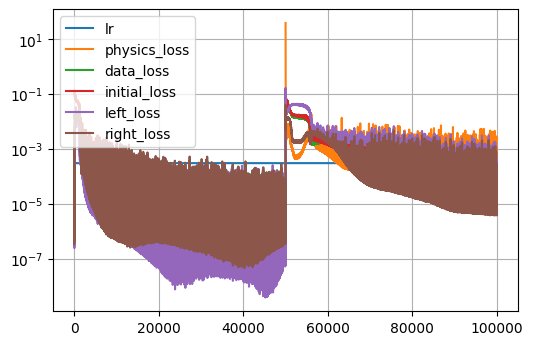

In [ ]:
import pandas as pd 

df = pd.DataFrame.from_dict(hist)
fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
ax.set_yscale('log')
df.plot(ax=ax, grid=True)

In [ ]:
from matplotlib import animation, rc
rc('animation', html='html5')

def update_plot(i, x, t):
    ax.clear()
    #pe = np.sin(2.*np.pi*(x-u*t[i]))
    #ax.plot(x, pe, label=f"exact (u = {U})")
    current_t = t[i]
    t_ = torch.full((x.shape[0],1), current_t)
    x_ = torch.from_numpy(x.reshape(-1,1).astype(np.float32))
    X = torch.concat((x_, t_), 1).to(device)
    p = pde.eval(X)
    #print(x_.shape, t_.shape, X.shape)
    p = p.cpu().numpy()
    #print(p[:,0].shape)
    #print(x.shape)
    ax.plot(x, p[:,0], '.k', label="solution")
    #print("Hello")
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("p", fontsize=14, rotation=np.pi/2)
    ax.legend(loc="upper right")
    ax.grid(True)
    ax.set_xlim([0, 1])
    ax.set_ylim([-1.0,1.0])
    #l2 = np.sqrt(np.sum((p[i]-pe)**2))
    ax.set_title(f"t = {t[i]:.3f}")
    return ax

In [ ]:
# evaluate

x = np.linspace(0,1.0,30)
t = np.linspace(0,1.0,20)

anim = animation.FuncAnimation(fig, update_plot, frames=len(t), fargs=(x, t), interval=300)
plt.close()

In [ ]:
# animation
anim

In [ ]:
state = {
    'epoch': 100000,
    'state_dict': mlp.state_dict(),
    'optimizer': optimizer.state_dict(),
    'history': hist
}
torch.save(state, 'model.pth')

In [ ]:
# load saved model
import torch
import numpy as np
import matplotlib.pyplot as plt
state = torch.load('model.pth', map_location=torch.device('cpu'))

In [ ]:
NUM_LAYERS = 5
NUM_HIDDEN = 100
mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN)
mlp.load_state_dict(state['state_dict'])
mlp.eval()

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Sequential(
      (0): Softplus(beta=1, threshold=20)
      (1): Linear(in_features=100, out_features=100, bias=True)
    )
    (2): Sequential(
      (0): Softplus(beta=1, threshold=20)
      (1): Linear(in_features=100, out_features=100, bias=True)
    )
    (3): Sequential(
      (0): Softplus(beta=1, threshold=20)
      (1): Linear(in_features=100, out_features=100, bias=True)
    )
    (4): Sequential(
      (0): Softplus(beta=1, threshold=20)
      (1): Linear(in_features=100, out_features=100, bias=True)
    )
    (5): Sequential(
      (0): Softplus(beta=1, threshold=20)
      (1): Linear(in_features=100, out_features=1, bias=True)
    )
  )
)

In [ ]:
import pandas as pd 

df = pd.DataFrame.from_dict(state['history'])
fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
ax.set_yscale('log')
df.plot(ax=ax, grid=True)

In [ ]:
device = 'cpu'

In [ ]:
pde.compile(mlp, '', '', loss_fn_physics = torch.nn.MSELoss(), loss_fn_boundary = torch.nn.MSELoss())

In [ ]:
from matplotlib import animation, rc
rc('animation', html='html5')

def update_plot(i, x, t):
    ax.clear()
    #pe = np.sin(2.*np.pi*(x-u*t[i]))
    #ax.plot(x, pe, label=f"exact (u = {U})")
    current_t = t[i]
    t_ = torch.full((x.shape[0],1), current_t)
    x_ = torch.from_numpy(x.reshape(-1,1).astype(np.float32))
    X = torch.concat((x_, t_), 1).to(device)
    p = pde.eval(X)
    #print(x_.shape, t_.shape, p.shape)
    np.savetxt('p_' + str(i) + '.txt', np.c_[x_[:,0].detach().numpy(),t_[:,0].detach().numpy(),p[:,0].detach().numpy()])
    p = p.cpu().numpy()
    #print(p[:,0].shape)
    #print(x.shape)
    ax.plot(x, p[:,0], '.k', label="solution")
    #print("Hello")
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("p", fontsize=14, rotation=np.pi/2)
    ax.legend(loc="upper right")
    ax.grid(True)
    ax.set_xlim([0, 1])
    ax.set_ylim([-1.0,1.0])
    #l2 = np.sqrt(np.sum((p[i]-pe)**2))
    ax.set_title(f"t = {t[i]:.3f}")
    return ax

In [ ]:
# evaluate and save for further analysis

fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
x = np.linspace(0,1.0,300)
t = np.linspace(0,2.0,600)

anim = animation.FuncAnimation(fig, update_plot, frames=len(t), fargs=(x, t), interval=300)
plt.close()

In [ ]:
# with initial and left and right and new analytic 500000 epochs
anim

In [ ]:
# with no data and initial and left and right and der loss 500000 epochs
anim

In [ ]:
# with no data and initial and left and right and der loss 500000 epochs more time
anim

In [ ]:
# with data and initial and left and right 500000 epochs more time
anim

In [ ]:
!tar -cvf simulation_results.tar *.txt